# Objective
The goal is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.

# Dataset
id - the id of a training set question pair

* qid1, qid2 - unique ids of each question   
* question1, question2 - the full text of each question  
* is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

In [0]:
#importing pandas
import pandas as pd 
import numpy as np
from nltk.corpus import stopwords
######
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
#read file
quest= pd.read_csv('/content/drive/My Drive/Quora_train.csv')

In [0]:
quest = quest.loc[0:500]
quest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            501 non-null    int64 
 1   qid1          501 non-null    int64 
 2   qid2          501 non-null    int64 
 3   question1     501 non-null    object
 4   question2     501 non-null    object
 5   is_duplicate  501 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 23.6+ KB


In [0]:
#removing ID columns
quest.drop(columns = 'id',inplace = True)

In [0]:
#romovng missing values
quest.dropna(inplace= True)
quest.reset_index(inplace=True)


Total Duplicate rows

In [0]:
#total no of duplicate pairs
duplicates = quest.duplicated().sum()
print('total number of duplicate pairs are {}'.format(duplicates))

total number of duplicate pairs are 0


Total no of unique questions

In [0]:
corpus = pd.concat([quest.question1,quest.question2])
duplicates = corpus.duplicated().sum()
print('Total no of unique questions are {}'.format(corpus.nunique()))
print('Total no of questions that appear more then one time are {}'.format((corpus.value_counts()>1).sum()))

Total no of unique questions are 999
Total no of questions that appear more then one time are 3


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


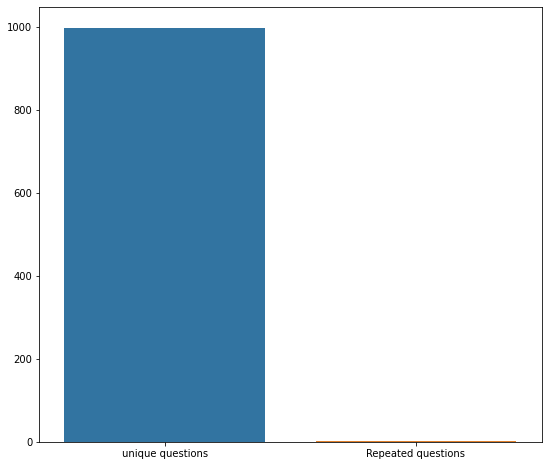

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
a = ["unique questions" , "Repeated questions"]
b =  [corpus.nunique() , (corpus.value_counts()>1).sum()]

plt.figure(figsize=(9, 8))
sns.barplot(a,b)
plt.show()

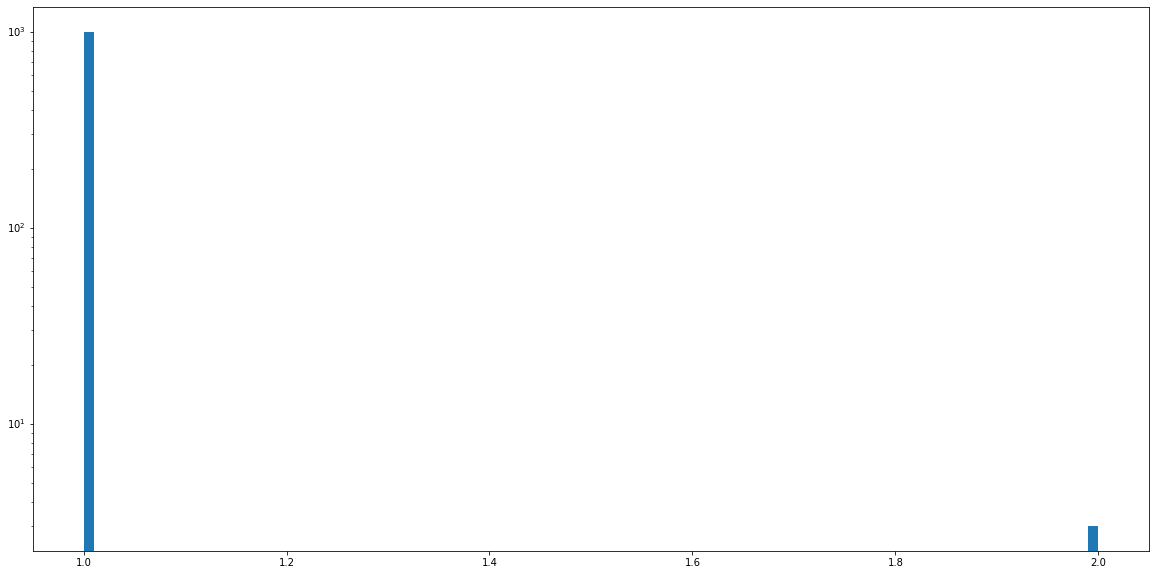

In [0]:
#no of time each question occurs
plt.figure(figsize=(20, 10))

plt.hist(corpus.value_counts(), bins=100)
plt.yscale('log')

Basic Feature Extraction:<br>
Let us now construct a few features like:<br>
freq_q1 = Frequency of qid1's<br>
freq_q2 = Frequency of qid2's<br>
q1_len = Length of q1<br>
q2_len = Length of q2<br>
q1_n_words = Number of words in Question 1<br>
q2_n_words = Number of words in Question 2<br>
word_Common = (Number of common words in Question 1 and Question 2)<br>
word_Total =(Total num of words in Question 1 + Total num of words in Question 2)<br>
word_share = (word_common)/(word_Total)<br>
freq_q1+freq_q2 = sum total of frequency of qid1 and qid2<br>
freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2<br>

In [0]:
quest.head()

,index,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
quest['freq_q1'] = quest.groupby('qid1')['qid1'].transform('count') 
quest['freq_q2'] = quest.groupby('qid2')['qid2'].transform('count')
quest['q1_len'] = quest['question1'].str.len() 
quest['q2_len'] = quest['question2'].str.len()
quest['q1_n_words'] = quest['question1'].apply(lambda row: len(row.split(" ")))
quest['q2_n_words'] = quest['question2'].apply(lambda row: len(row.split(" ")))
#common words in question 1 & 2
c_w=[]
t_w=[]
n_w_c = []
for i in range(quest.shape[0]):
  w1 = quest.question1[i].lower().strip().split()
  w2 = quest.question2[i].lower().strip().split()
  uni_1 = []
  uni_2 = []
  [uni_1.append(x) for x in w1 if x not in uni_1]
  [uni_2.append(x) for x in w2 if x not in uni_2]
  a = [i for i in uni_1 if i in uni_2]
  c_w.append(len(a))
  t_w.append(len(uni_1)+len(uni_2))
  n_w_c.append(len(a)/(len(uni_1)+len(uni_2)))

quest['common_words'] = pd.Series(c_w)
quest['Total_words_q1_q2'] = pd.Series(t_w)
quest['normalised_word_count'] = pd.Series(n_w_c)
quest['freq_q1+q2'] = quest['freq_q1']+quest['freq_q2']
quest['freq_q1-q2'] = abs(quest['freq_q1']-quest['freq_q2'])

In [0]:
quest.head()

,index,qid1,qid2,question1,question2,is_duplicate,freq_q1,freq_q2,q1_len,q2_len,q1_n_words,q2_n_words,common_words,Total_words_q1_q2,normalised_word_count,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4,20,0.200000,2,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2,20,0.100000,2,0


In [0]:
print ("Minimum length of the questions in question1 : " , min(quest['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(quest['q2_n_words']))

print ("Number of Questions in question 1 columns with minimum length :", len(quest[quest.q1_n_words== 1].index))
print ("Number of Questions in question 2 columns with minimum length :",  len(quest[quest.q2_n_words== 1].index))

Minimum length of the questions in question1 :  3
Minimum length of the questions in question2 :  3
Number of Questions in question 1 columns with minimum length : 0
Number of Questions in question 2 columns with minimum length : 0


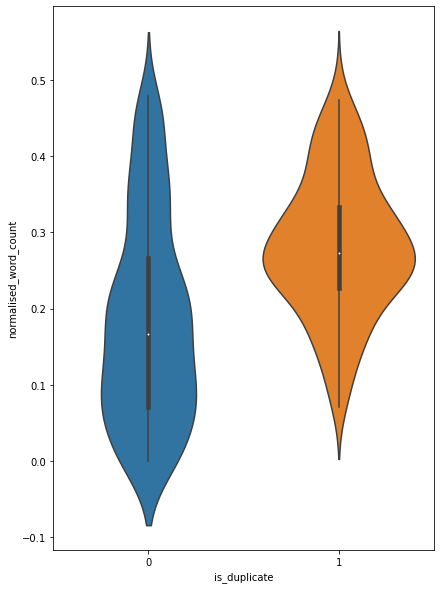

In [0]:
plt.figure(figsize=(15, 10))
plt.subplot(1,2,1)
sns.violinplot(x = quest.is_duplicate, y = quest.normalised_word_count)


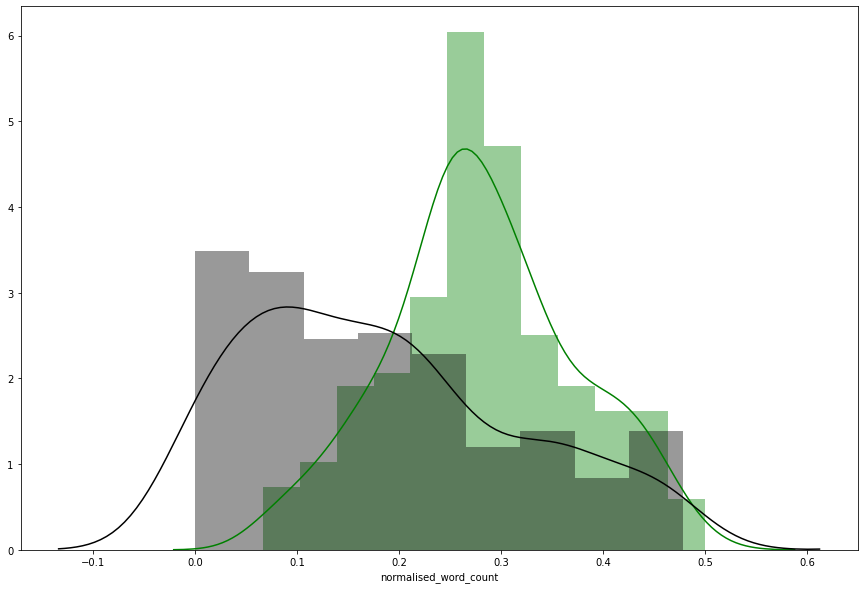

In [0]:
plt.figure(figsize=(15, 10))

sns.distplot(quest.loc[quest.is_duplicate == 1.0].normalised_word_count, label = "1", color = 'green')
sns.distplot(quest.loc[quest.is_duplicate == 0.0].normalised_word_count , label = "0" , color = 'black' )

plt.show()

In [0]:
#Defining Stopwords
STOP_WORDS = stopwords.words("english")
snow = nltk.stem.SnowballStemmer('english')
def cleaner(sentence):
  words = []
  sent = []
  stopwords = nltk.corpus.stopwords.words('english')
  import re
  sentence = sentence.lower()                 # Converting to lowercase
  cleanr = re.compile('<.*?>')
  sentence = re.sub(cleanr, ' ', sentence)        #Removing HTML tags
  sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
  sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)       #Removing Punctuations
  sentence = re.sub(r"'ll",r'will',sentence)
  sentence = re.sub(r"he's", "he is",sentence)
  sentence = re.sub(r"i'm",r'i am',sentence)
  for i in sentence.split():
    words.append(snow.stem(i))
  sequ = ''
  for word in words:
    if word not in STOP_WORDS:
      sequ = sequ + ' ' + word   

  return sequ


In [0]:

#cleaning data
quest.question1 = quest.question1.apply(lambda x: cleaner(x))
quest.question2 = quest.question2.apply(lambda x: cleaner(x))

In [0]:
#removing null string
def null_sttring_remover(x):
  if x == '':
    return np.NAN
  else:
    return x
quest.question1 = quest.question1.apply(lambda x: null_sttring_remover(x))
quest.question2 = quest.question2.apply(lambda x: null_sttring_remover(x))

In [0]:
#romovng missing values
quest.dropna(inplace= True)

In [0]:
#reseting index after removing rows
quest = quest.reset_index()
quest

,level_0,index,qid1,qid2,question1,question2,is_duplicate,freq_q1,freq_q2,q1_len,q2_len,q1_n_words,q2_n_words,common_words,Total_words_q1_q2,normalised_word_count,freq_q1+q2,freq_q1-q2
0,0,0,1,2,step step guid invest share market india,step step guid invest share market,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,1,3,4,stori kohinoor koh-i-noor diamond,would happen indian govern stole kohinoor koh...,0,1,1,51,88,8,13,4,20,0.200000,2,0
2,2,2,5,6,increas speed internet connect use vpn,internet speed increas hack dns,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,3,7,8,whi mental veri lone solv,find remaind [math]23^{24}[ math] divid 24 23,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,4,9,10,one dissolv water quik sugar salt methan carb...,fish would surviv salt water,0,1,1,76,39,13,7,2,20,0.100000,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,496,496,990,991,major highway california compar major highway...,major highway california compar major highway...,0,1,1,104,100,18,18,12,26,0.461538,2,0
497,497,497,992,993,beyond univers,space expand doe new space come,0,1,1,27,58,4,11,0,14,0.000000,2,0
498,498,498,994,995,grow hair physic chemic chang,bald person ever grow hair back,0,1,1,51,44,10,9,2,18,0.111111,2,0
499,499,499,996,997,differ cultur histori,chili differ cultur,0,1,1,51,40,8,6,2,14,0.142857,2,0


• **common_token_count_max** : Ratio of common_token_count to max lenghth of token count of question 1 and
question 2 common_token_count_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))<br><br>
• **last_word_eq** : Check if Last word of both questions are equal or not last_word_eq =
int(q1_tokens[-1] == q2_tokens[-1])<br><br>
• **first_word_eq** : If First word of both questions is equal then True else False.
int(q1_tokens[0] == q2_tokens[0])<br><br>
• **abs_len_diff** : Abs. length differenceabs_len_diff = abs(len(q1_tokens) - len(q2_tokens))<br><br>
• **mean_len** : Average Token Length of both Questions mean_len = (len(q1_tokens) +
len(q2_tokens))/2<br><br>
• **fuzz_ratio** :FuzzyWuzzy has, just like the Levenshtein package, a ratio function that computes the standard Levenshtein distance similarity ratio between two sequences.Levenshtein distance measures the minimum number of edits that you need to do to change a one-word sequence into the other. These edits can be insertions, deletions or substitutions.<br><br>
• **fuzz_partial_ratio** : The way fuzz_partial_ratio works is by using an "optimal partial" logic. In other words, if the short string has length k and 
the longer string has the length m, then the algorithm seeks the score of the best matching length-k substring.<br><br>
• **token_sort_ratio** : The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and
then joining them back into a string We then compare the transformed strings with a simple ratio().<br><br>
• **token_set_ratio** : fuzz.token_set_ratio() takes a more flexible approach than fuzz.token_sort_ratio().Instead of just tokenizing the strings, 
sorting and then pasting the tokens back together, token_set_ratio performs a set operation that takes out the common tokens (the intersection) 
and then makes fuzz.ratio() pairwise comparisons between the following new strings:<br><br>
s1 = Sorted_tokens_in_intersection<br>
s2 = Sorted_tokens_in_intersection + sorted_rest_of_str1_tokens<br>
s3 = Sorted_tokens_in_intersection + sorted_rest_of_str2_tokens<br>The logic behind these comparisons is that since Sorted_tokens_in_intersection is always the same, the score will tend to go up as these words make up a larger chunk of the original strings or the remaining tokens are closer to each other.<br><br>
• **longest_substr_ratio** : Ratio of length longest common substring to min 
lenghth of
token count of Q1 and Q2longest_substr_ratio = <br>len(longest common substring) /
(min(len(q1_tokens), len(q2_tokens))


In [0]:
#common_word_count_min
def common_word_count_min(x):
  # Converting the Sentence into Tokens: 
  q1_tokens = x.question1.split()
  q2_tokens = x.question2.split()

  # Get the non-stopwords in Questions
  q1_words = set([word for word in q1_tokens])
  q2_words = set([word for word in q2_tokens])

  cwc_min =  len(q1_words.intersection(q2_words)) / (min(len(q1_words), len(q2_words)))
  return cwc_min


#common_word_count_max
def common_word_count_max(x):
  # Converting the Sentence into Tokens: 
  q1_tokens = x.question1.split()
  q2_tokens = x.question2.split()
  # Get the non-stopwords in Questions
  q1_words = set([word for word in q1_tokens])
  q2_words = set([word for word in q2_tokens])

  cwc_max =  len(q1_words.intersection(q2_words)) / (max(len(q1_words), len(q2_words)))
  return cwc_max



#last_word_eq
def last_word_eq(x):
  # Converting the Sentence into Tokens: 
  q1_tokens = x.question1.split()
  q2_tokens = x.question2.split()

  # Get the non-stopwords in Questions
  q1_words = set([word for word in q1_tokens])
  q2_words = set([word for word in q2_tokens])

  # Last word of both question is same or not
  last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
  return last_word_eq

#first_word_eq
def first_word_eq(x):
  # Converting the Sentence into Tokens: 
  q1_tokens = x.question1.split()
  q2_tokens = x.question2.split()

  # Get the non-stopwords in Questions
  q1_words = set([word for word in q1_tokens])
  q2_words = set([word for word in q2_tokens])

  # Last word of both question is same or not
  first_word_eq = int(q1_tokens[0] == q2_tokens[0])
  return first_word_eq

#abs_len_diff
def abs_len_diff(x):
  # Converting the Sentence into Tokens: 
  q1_tokens = x.question1.split()
  q2_tokens = x.question2.split()

  # Get the non-stopwords in Questions
  q1_words = set([word for word in q1_tokens])
  q2_words = set([word for word in q2_tokens])

  # Last word of both question is same or not
  abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
  return abs_len_diff


#mean_len
def mean_len(x):
  # Converting the Sentence into Tokens: 
  q1_tokens = x.question1.split()
  q2_tokens = x.question2.split()

  # Get the non-stopwords in Questions
  q1_words = set([word for word in q1_tokens])
  q2_words = set([word for word in q2_tokens])

  #Average Token Length of both Questions
  mean_len = (len(q1_tokens) + len(q2_tokens))/2
  return mean_len

#get_longest_substr_ratio
def get_longest_substr_ratio(a, b):
  strs = list(distance.lcsubstrings(a, b))
  if len(strs) == 0:
    return 0
  else:
    return len(strs[0]) / (min(len(a), len(b)) + 1)


#common_token_count_min
def common_token_count_min(x):
  # Converting the Sentence into Tokens: 
  q1_tokens = x.question1.split()
  q2_tokens = x.question2.split()

  # Get the non-stopwords in Questions
  q1_words = set([word for word in q1_tokens])
  q2_words = set([word for word in q2_tokens])

  ctc_min =  len(set(q1_tokens).intersection(set(q2_tokens))) / (min(len(q1_tokens), len(q2_tokens)))
  return ctc_min

#common_token_count_max
def common_token_count_max(x):
  # Converting the Sentence into Tokens: 
  q1_tokens = x.question1.split()
  q2_tokens = x.question2.split()

  # Get the non-stopwords in Questions
  q1_words = set([word for word in q1_tokens])
  q2_words = set([word for word in q2_tokens])

  ctc_max =  len(set(q1_tokens).intersection(set(q2_tokens))) / (max(len(q1_tokens), len(q2_tokens)))
  return ctc_max

In [0]:
quest.apply(lambda x: common_word_count_min(x), axis =1)

0      1.000000
1      0.750000
2      0.600000
3      0.000000
4      0.400000
         ...   
496    0.800000
497    0.000000
498    0.400000
499    0.666667
500    0.800000
Length: 501, dtype: float64

In [0]:
quest["common_word_count_min"] = quest.apply(lambda x: common_word_count_min(x), axis =1)
quest["common_word_count_max"] = quest.apply(lambda x: common_word_count_max(x), axis =1)
quest["common_token_count_min"] = quest.apply(lambda x: common_token_count_min(x), axis =1)
quest["common_token_count_max"] = quest.apply(lambda x: common_token_count_max(x), axis =1)
quest["last_word_eq"] = quest.apply(lambda x: last_word_eq(x), axis =1)
quest["first_word_eq"] = quest.apply(lambda x: first_word_eq(x), axis =1)
quest["abs_len_diff"] = quest.apply(lambda x: abs_len_diff(x), axis =1)
quest["mean_len"] = quest.apply(lambda x: mean_len(x), axis =1)

In [0]:
#installing and importing fuzzywuzzy
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz



quest["token_set_ratio"] = quest.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)



quest["token_sort_ratio"] = quest.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)



quest["fuzz_ratio"] = quest.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)



quest["fuzz_partial_ratio"] = quest.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [0]:
!pip install Distance

import distance
quest["longest_substr_ratio"] = quest.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)

     |████████████████████████████████| 184kB 2.8MB/s 
  Created wheel for Distance: filename=Distance-0.1.3-cp36-none-any.whl size=16261 sha256=b0b19639bec05a69e9ee0938cc60cf47f8871ecd22eebfe8377f209784e9a620
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built Distance


In [0]:
#creating a corpus to create word embeddings
corpus = list(quest.question1+quest.question2)

In [0]:
#vectorizing sentence using tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer  
tf_idf = TfidfVectorizer()
tf_data1 = tf_idf.fit_transform(corpus)

In [0]:
# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tf_idf.get_feature_names(), tf_idf.idf_))


• After we find TF-IDF scores, we convert each question to a weighted average of word2vec
vectors by these scores.<br>
• here we use a pre-trained GLOVE model which comes free with "Spacy".
https://spacy.io/usage/vectors-similarity<br>
• It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.

In [0]:
# tqdm is used to print the progress bar
from tqdm import tqdm
import en_core_web_sm
nlp = en_core_web_sm.load()
vecs1 = []
for qu1 in tqdm(list(quest['question1'])):
  doc1 = nlp(qu1)
  # 96 is the number of dimensions of vectors
  mean_vec1 = np.zeros([len(doc1), 96])
  for word1 in doc1:
    # word2vec
    vec1 = word1.vector
    # fetch df score
    try:
      tf_idf = word2tfidf[str(word1)]
    except:
      tf_idf = 0
    # compute final vec
    mean_vec_1 =mean_vec1+ np.dot(vec1, tf_idf)
  mean_vec1 = mean_vec_1.mean(axis=0)
  vecs1.append(mean_vec1)

  0%|          | 48/404179 [00:00<1:12:26, 92.97it/s]


KeyboardInterrupt: ignored

In [0]:
from tqdm import tqdm
import en_core_web_sm
nlp = en_core_web_sm.load()
vecs2 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(quest['question2'])):
  doc1 = nlp(qu1)
  # 94 is the number of dimensions of vectors
  mean_vec1 = np.zeros([len(doc1), 96])
  for word1 in doc1:
    # word2vec
    vec1 = word1.vector
    # fetch df score
    try:
      idf = word2tfidf[str(word1)]
    except:
      idf = 0
    # compute final vec
    mean_vec1 += np.dot(vec1, idf)
  mean_vec1 = mean_vec1.mean(axis=0)
  vecs2.append(mean_vec1)

100%|██████████| 404179/404179 [55:22<00:00, 121.64it/s]


In [0]:
#quest.drop(columns=['q2_feats_m','q1_feats_m'],inplace=True)
quest.drop(columns = ['common_token_count_max'],inplace=True)

In [0]:
final_quora_f.to_csv('final_quora_f.csv')

In [0]:
!cp final_quora_f.csv "drive/My Drive/"

In [0]:
quest = pd.read_csv('/content/drive/My Drive/quora_f.csv')

In [0]:
a = pd.DataFrame(vecs1)
column_name = []
for i in range(0,96):
  column_name.append("q1_{}".format(i))
a.columns = column_name

In [0]:
b = pd.DataFrame(vecs2)
column_name = []
for i in range(0,96):
  column_name.append("q2_{}".format(i))
b.columns = column_name

In [0]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
questp_subsampled = quest[0:5000]
X = MinMaxScaler().fit_transform(questp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' , 'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = questp_subsampled['is_duplicate'].values
tsne2d = TSNE(n_components=2,init='random',random_state=101,method='barnes_hut',n_iter=1000,verbose=2,angle=0.5,).fit_transform(X)


KeyError: ignored

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


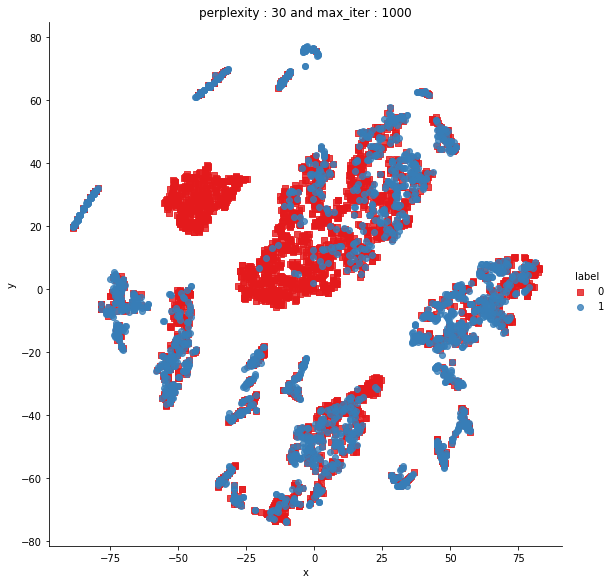

In [0]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})
# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

https://www.kaggle.com/c/quora-question-pairs <br>
https://www.datacamp.com/community/tutorials/fuzzy-string-python <br>
https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0 <br>
https://towardsdatascience.com/machine-learning-text-processing-1d5a2d638958 <br>
https://medium.com/deepdatascience/feature-extraction-from-text-text-data-preprocessing-594b11af19f5 <br>
https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb<br>
https://www.kaggle.com/shashanksai/text-preprocessing-using-python

